In [1]:
import numpy as np
import pandas as pda

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
#tf.__version__

C:\Users\kduar_000\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Download the mnist dataset using keras
data_train, data_test = tf.keras.datasets.mnist.load_data()

# Parse images and labels
(images_train, labels_train) = data_train
(images_test, labels_test) = data_test

In [4]:
images_train.shape, labels_train.shape, images_test.shape, labels_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

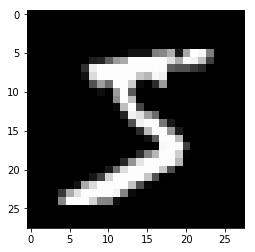

In [5]:
import matplotlib.pyplot as plt
plt.imshow(images_train[0], cmap="gray")
plt.show()

In [6]:
def prepare_batch(Data, Label, batch_size):
    batch_indice = np.random.randint(0, Data.shape[0], batch_size)
    batch_datas = np.array([Data[index] for index in batch_indice]) 
    batch_labels = np.array([Label[index] for index in batch_indice])
    return batch_datas, batch_labels

Shape of Batch (3, 28, 28) (3,)


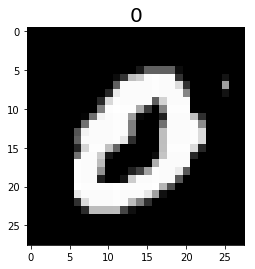

In [7]:
X_batch, y_batch = prepare_batch(images_train, labels_train, 3)
print("Shape of Batch", X_batch.shape, y_batch.shape)
plt.imshow(X_batch[0], cmap="gray")
plt.title(y_batch[0], fontsize= "20")
plt.show()

In [8]:
tf.reset_default_graph()

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width], name="X")
    reshaped_X = tf.reshape(X, shape = [-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    keep_prob = tf.placeholder(tf.float32)
    is_training = tf.placeholder(tf.bool)

conv1 = tf.layers.conv2d(reshaped_X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=None, name="conv1")

conv1_drop = tf.layers.dropout(conv1, rate = keep_prob, training = is_training)
conv1_out  = tf.nn.relu(conv1_drop)

conv2 = tf.layers.conv2d(conv1_out, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=None, name="conv2")

conv2_drop = tf.layers.dropout(conv2, rate = keep_prob, training = is_training)
conv2_out  = tf.nn.relu(conv2_drop)


with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [9]:
n_epochs = 10
batch_size = 64

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(images_train)// batch_size):
            X_batch, y_batch = prepare_batch(images_train, labels_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, 
                                             keep_prob: 0.5, is_training: True})
            
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch, 
                                             keep_prob: 1.0, is_training: False})
        acc_test = accuracy.eval(feed_dict={X: images_test, y: labels_test, 
                                            keep_prob: 1.0, is_training: False})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.984375 Test accuracy: 0.9647
1 Train accuracy: 1.0 Test accuracy: 0.9799
2 Train accuracy: 1.0 Test accuracy: 0.9811
3 Train accuracy: 1.0 Test accuracy: 0.9819
4 Train accuracy: 1.0 Test accuracy: 0.9825
5 Train accuracy: 1.0 Test accuracy: 0.9856
6 Train accuracy: 1.0 Test accuracy: 0.9838
7 Train accuracy: 0.984375 Test accuracy: 0.9854
8 Train accuracy: 0.96875 Test accuracy: 0.9865
9 Train accuracy: 1.0 Test accuracy: 0.9885


In [10]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [11]:
show_graph(tf.get_default_graph())